In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim  as optim
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import torchvision 
from torchvision import datasets,transforms
import shutil

C:\Users\22789\Anaconda3\envs\pytorch_py\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
base_dir = r'C:\Users\22789\Desktop\学校课程学习\路飞python\4weather'
train_dir = os.path.join(base_dir,'train')
test_dir = os.path.join(base_dir,'test')

In [4]:
model = torchvision.models.resnet101(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to C:\Users\22789/.cache\torch\hub\checkpoints\resnet101-5d3b4d8f.pth
100%|████████████████████████████████████████████████████████████████████████████████| 170M/170M [25:41<00:00, 116kB/s]


In [6]:
train_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.RandomCrop(192),
    transforms.RandomHorizontalFlip(),#左右水平反转
    transforms.RandomRotation(0.2), #随机旋转
    transforms.ColorJitter(brightness=0.5),#改变明暗度
    transforms.ColorJitter(contrast=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5,.5,.5],std=[.5,.5,.5])
])                                                            

In [7]:
test_transform = transforms.Compose([
    transforms.Resize((192,192)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5,.5,.5],std=[.5,.5,.5])
])

In [8]:
train_ds = torchvision.datasets.ImageFolder(
        train_dir,
        transform = train_transform
)

In [9]:
test_ds = torchvision.datasets.ImageFolder(
    test_dir,
    transform = test_transform
)

In [10]:
batch = 20
train_dl = torch.utils.data.DataLoader(
    train_ds,
    batch_size = batch,
    shuffle =True
)
test_dl = torch.utils.data.DataLoader(
    test_ds,batch_size = batch
)

In [12]:
for p in model.parameters():
    p.requires_grad = False

In [13]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [24]:
model.fc.out_features = 4 
for x in model.fc.parameters():
    x.requires_grad = True

In [15]:
model.fc

Linear(in_features=2048, out_features=4, bias=True)

In [17]:
opt = optim.Adam(model.fc.parameters(),lr=0.001)

In [22]:
loss_fn = nn.CrossEntropyLoss()

In [18]:
from torch.optim import lr_scheduler
lr_sc = lr_scheduler.StepLR(opt,step_size = 5,gamma=0.9)

In [19]:
device = torch.device('cuda:0' if torch.cuda.is_available else 'cpu')
model = model.to(device)

In [20]:
def fit(epoch, model, trainloader, testloader):
    correct = 0
    total = 0
    running_loss = 0
    model.train()
    for x, y in trainloader:
        if torch.cuda.is_available():
            x, y = x.to(device), y.to(device)
            y_pred = model(x)
            loss = loss_fn(y_pred, y)
            opt.zero_grad()
            loss.backward()
            opt.step()
        with torch.no_grad():
            y_pred = torch.argmax(y_pred, dim=1)
            correct += (y_pred == y).sum().item()
            total += y.size(0)
            running_loss += loss.item()
#     if epoch%5 == 0:
#         for p in opt.param_groups:
#             p['lr'] *= 0.5
    lr_sc.step()
    epoch_loss = running_loss / len(trainloader.dataset)
    epoch_acc = correct / total
        
        
    test_correct = 0
    test_total = 0
    test_running_loss = 0 
    
    model.eval()
    with torch.no_grad():
        for x, y in testloader:
            if torch.cuda.is_available():
                x, y = x.to(device), y.to(device)
                y_pred = model(x)
                loss = loss_fn(y_pred, y)
                y_pred = torch.argmax(y_pred, dim=1)
                test_correct += (y_pred == y).sum().item()
                test_total += y.size(0)
                test_running_loss += loss.item()
    
    epoch_test_loss = test_running_loss / len(testloader.dataset)
    epoch_test_acc = test_correct / test_total
    
        
    print('epoch: ', (epoch+1), 
          'loss： ', round(epoch_loss, 3),
          'accuracy:', round(epoch_acc, 3),
          'test_loss： ', round(epoch_test_loss, 3),
          'test_accuracy:', round(epoch_test_acc, 3)
             )
        
    return epoch_loss, epoch_acc, epoch_test_loss, epoch_test_acc

In [25]:
train_loss = []
train_acc = []
test_loss = []
test_acc = []

epochs = 30
for epoch in range(epochs):
    epoch_loss, epoch_acc, epoch_test_loss, epoch_test_acc=fit(epoch,model,train_dl,test_dl)
    
    
    train_loss.append(epoch_loss)
    train_acc.append(epoch_acc)
    test_loss.append(epoch_test_loss)
    test_acc.append(epoch_test_acc)

epoch:  1 loss：  0.114 accuracy: 0.326 test_loss：  0.043 test_accuracy: 0.658
epoch:  2 loss：  0.032 accuracy: 0.75 test_loss：  0.021 test_accuracy: 0.867
epoch:  3 loss：  0.022 accuracy: 0.838 test_loss：  0.015 test_accuracy: 0.893
epoch:  4 loss：  0.017 accuracy: 0.874 test_loss：  0.011 test_accuracy: 0.938
epoch:  5 loss：  0.014 accuracy: 0.917 test_loss：  0.01 test_accuracy: 0.951
epoch:  6 loss：  0.012 accuracy: 0.924 test_loss：  0.009 test_accuracy: 0.938
epoch:  7 loss：  0.012 accuracy: 0.912 test_loss：  0.009 test_accuracy: 0.947
epoch:  8 loss：  0.012 accuracy: 0.918 test_loss：  0.011 test_accuracy: 0.933
epoch:  9 loss：  0.011 accuracy: 0.928 test_loss：  0.009 test_accuracy: 0.929
epoch:  10 loss：  0.01 accuracy: 0.934 test_loss：  0.009 test_accuracy: 0.933
epoch:  11 loss：  0.009 accuracy: 0.946 test_loss：  0.008 test_accuracy: 0.942
epoch:  12 loss：  0.009 accuracy: 0.939 test_loss：  0.008 test_accuracy: 0.938
epoch:  13 loss：  0.009 accuracy: 0.937 test_loss：  0.008 test_a

In [28]:
model.state_dict()

OrderedDict([('conv1.weight',
              tensor([[[[ 2.0222e-02, -4.3927e-03, -1.8274e-02,  ..., -1.5180e-02,
                         -1.5794e-03,  9.3115e-03],
                        [-4.0752e-03,  3.2116e-03, -1.5956e-02,  ..., -8.4465e-02,
                         -7.4997e-02, -4.0676e-02],
                        [ 3.5039e-03,  2.6746e-02,  5.0813e-02,  ...,  3.3407e-02,
                          1.3659e-02,  2.7821e-02],
                        ...,
                        [-3.6174e-02, -1.2986e-01, -3.0369e-01,  ..., -3.7412e-01,
                         -1.3025e-01,  4.2633e-02],
                        [ 1.5479e-02,  2.3444e-02,  6.5222e-03,  ..., -1.6439e-01,
                         -1.8245e-01, -9.7434e-02],
                        [-3.0444e-02, -1.1357e-02,  4.9984e-02,  ...,  1.6412e-01,
                          1.0419e-01, -1.2681e-02]],
              
                       [[ 8.7115e-03, -5.8911e-03, -1.2204e-02,  ..., -1.3515e-02,
                          1.5212

In [29]:
for p in model.parameters():
    p.requires_grad = True

In [30]:
import copy

In [31]:
best_model = copy.deepcopy(model.state_dict())
best_acc = 0
train_loss = []
train_acc = []
test_loss = []
test_acc = []

epochs = 10
for epoch in range(epochs):
    epoch_loss, epoch_acc, epoch_test_loss, epoch_test_acc=fit(epoch,model,train_dl,test_dl)
    
    if epoch_test_acc < best_acc:
        best_model = copy.deepcopy(model.state_dict())
        best_acc = epoch_test_acc
    train_loss.append(epoch_loss)
    train_acc.append(epoch_acc)
    test_loss.append(epoch_test_loss)
    test_acc.append(epoch_test_acc)

epoch:  1 loss：  0.006 accuracy: 0.95 test_loss：  0.008 test_accuracy: 0.956
epoch:  2 loss：  0.007 accuracy: 0.953 test_loss：  0.008 test_accuracy: 0.947
epoch:  3 loss：  0.006 accuracy: 0.961 test_loss：  0.007 test_accuracy: 0.96
epoch:  4 loss：  0.007 accuracy: 0.947 test_loss：  0.007 test_accuracy: 0.947
epoch:  5 loss：  0.006 accuracy: 0.961 test_loss：  0.007 test_accuracy: 0.956
epoch:  6 loss：  0.007 accuracy: 0.954 test_loss：  0.007 test_accuracy: 0.956
epoch:  7 loss：  0.007 accuracy: 0.939 test_loss：  0.007 test_accuracy: 0.96
epoch:  8 loss：  0.005 accuracy: 0.969 test_loss：  0.007 test_accuracy: 0.951
epoch:  9 loss：  0.007 accuracy: 0.949 test_loss：  0.007 test_accuracy: 0.951
epoch:  10 loss：  0.006 accuracy: 0.961 test_loss：  0.007 test_accuracy: 0.956


# 保存模型

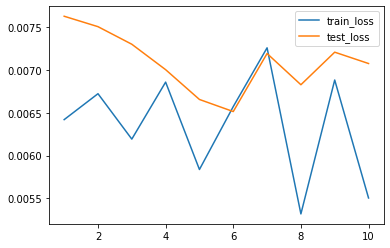

In [32]:
plt.plot(range(1,epochs+1),train_loss,label='train_loss')
plt.plot(range(1,epochs+1),test_loss,label='test_loss')
plt.legend()

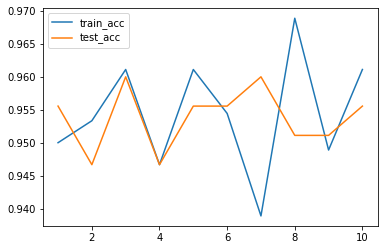

In [33]:
plt.plot(range(1,epochs+1),train_acc,label='train_acc')
plt.plot(range(1,epochs+1),test_acc,label='test_acc')
plt.legend()